### Calculating SV mutation rate from centrolign pairwise cigars

In [1]:
# Import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [ ]:
## Read in patristic distances 
path = "/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/tree_pair_dist/"   # change to your directory

files = glob.glob(os.path.join(
    path,
    "*_r2_QC_v2_centrolign_all_pairs_nj_tree.nwk.pair_dists.tsv"
))

dfs = []

for f in files:
    # extract chromosome name from filename
    base = os.path.basename(f)
    chr_name = base.split("_")[0]

    # read the tsv file (tab-separated)
    df = pd.read_csv(f, sep="\t")

    # add chr column
    df["chr"] = chr_name

    dfs.append(df)

# combine all files
patristic_dist_df = pd.concat(dfs, ignore_index=True)
patristic_dist_df.columns = ["sample1", "sample2", "patristic_dist","chr"]
print(patristic_dist_df)


           sample1    sample2  patristic_dist    chr
0          CHM13.0  NA18943.1        0.663738  chr15
1          CHM13.0  NA20503.2        0.667764  chr15
2          CHM13.0  HG00126.1        0.825706  chr15
3          CHM13.0  HG00329.2        0.826127  chr15
4          CHM13.0  HG00741.2        0.834431  chr15
...            ...        ...             ...    ...
1132390  NA18960.2  HG02074.1        0.363382  chr13
1132391  NA18960.2  HG02027.1        0.326459  chr13
1132392  NA18976.1  HG02074.1        0.366276  chr13
1132393  NA18976.1  HG02027.1        0.329353  chr13
1132394  HG02074.1  HG02027.1        0.065755  chr13

[1132395 rows x 4 columns]


In [2]:
## Read in summary files containing counts of each type of SV per sample pair 

# Path to the file containing locations of summary files for all subgroups 
list_file = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/all_chrom_SV_summary.txt"

dfs = []

with open(list_file, "r") as f:
    for line in f:
        filepath = line.strip()
        if not filepath:
            continue
        
        # Extract filename (no directories)
        filename = os.path.basename(filepath)

        # Filename format: ${chr}.${subgroup}.SV_summary.txt
        # Example: "chr3.subgroup_A.SV_summary.txt"
        chr_name, subgroup, _ = filename.split(".", 2)

        # Read TSV
        df = pd.read_csv(
            filepath,
            sep="\t",
            header=None,
            names=["sample1", "sample2", "triangles", "parallelograms", "trapezoids"]
        )

        # Add metadata columns
        df["chr"] = chr_name
        df["subgroup"] = subgroup

        dfs.append(df)

# Combine all results
all_df = pd.concat(dfs, ignore_index=True)

print(all_df)

          sample1    sample2  triangles  parallelograms  trapezoids    chr  \
0       HG00099.2    HG002.2        212             104         212   chr5   
1       HG00099.2  HG00558.2        206             104         210   chr5   
2       HG00099.2  HG00597.2        240             112         230   chr5   
3       HG00099.2  HG00609.2        244             110         232   chr5   
4       HG00099.2  HG00658.1        226             100         221   chr5   
...           ...        ...        ...             ...         ...    ...   
536534  NA21110.2  NA20805.1         93             140         133  chr16   
536535  NA21110.2  NA20805.2        138              70          91  chr16   
536536  NA21110.2  NA20806.2        106              14          34  chr16   
536537  NA21110.2  NA21093.1          7               6           9  chr16   
536538  NA21110.2  NA21106.2        100             132         146  chr16   

                subgroup  
0         chr5_subgroup0  
1        

In [3]:
## read in all pairs distances 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    print(df)
    all_dfs.append(df)

# Combine into one dataframe
dist_df = pd.concat(all_dfs, ignore_index=True)

         sample1    sample2  direct_pairwise_dist   chr
0      HG03098.1  HG03784.1              0.942968  chr6
1      HG03098.1  NA20752.2              0.974936  chr6
2      HG01978.2  NA19835.1              0.999883  chr6
3      HG00741.1  NA18522.1              0.999869  chr6
4      HG00408.1  HG01496.1              0.606856  chr6
...          ...        ...                   ...   ...
18716  HG03239.1  NA18508.2              0.972884  chr6
18717  HG01496.1  HG02738.2              0.727958  chr6
18718  HG02109.1  NA18565.1              0.972740  chr6
18719  HG00126.1  NA20827.1              0.999998  chr6
18720  HG02135.2  NA19240.1              0.861468  chr6

[18721 rows x 4 columns]
         sample1    sample2  direct_pairwise_dist    chr
0      HG01993.2  HG02841.1              0.995948  chr19
1      HG00133.1  HG01192.2              0.999991  chr19
2      HG00126.2  HG01106.2              0.293821  chr19
3      HG01952.2  HG02280.2              0.992413  chr19
4      HG00344.2 

In [4]:
# create new columns s1 and s2 where sample1 and 2 are sorted, so we can merge dfs
def sort_samples(df):
    df = df.copy()
    df[["s1","s2"]] = (
        df[["sample1", "sample2"]]
        .apply(lambda x: sorted(x), axis=1, result_type="expand")
    )
    return df

all_df_c = sort_samples(all_df)
dist_df_c = sort_samples(dist_df)
pat_df_c = sort_samples(patristic_dist_df)

# Drop the sample1/sample2 columns from the dataframes being merged in
dist_df_c = dist_df_c.drop(columns=["sample1", "sample2"])
pat_df_c  = pat_df_c.drop(columns=["sample1", "sample2"])

# merge dataframes 
merged = (
    all_df_c
    .merge(dist_df_c, on=["s1", "s2", "chr"], how="left")
    .merge(pat_df_c, on=["s1", "s2", "chr"], how="left")
)
merged = merged.drop(columns=["s1", "s2"])
print(merged)

NameError: name 'patristic_dist_df' is not defined

In [ ]:
## calculate mutation rate across all pairwise dist values 

shape_cols = ["triangles", "parallelograms", "trapezoids"]

for chr_id, df_chr in merged.groupby("chr"):

    print(f"\nChromosome: {chr_id}")

    for col in shape_cols:
        ratio = df_chr[col] / df_chr["patristic_dist"]
        mutation_rate = ratio.sum() / len(df_chr)

        print(f"  {col} mutation rate: {mutation_rate}")



Chromosome: chr1
  triangles mutation rate: 470.4224298133597
  parallelograms mutation rate: 100.44695905806937
  trapezoids mutation rate: 304.5172741909673

Chromosome: chr10
  triangles mutation rate: 96.36526733542209
  parallelograms mutation rate: 28.621363932262597
  trapezoids mutation rate: 96.86660304612286

Chromosome: chr11
  triangles mutation rate: 306.5784298928303
  parallelograms mutation rate: 98.49127023998146
  trapezoids mutation rate: 273.57751827795016

Chromosome: chr12
  triangles mutation rate: 140.06282330294542
  parallelograms mutation rate: 52.56920201118839
  trapezoids mutation rate: 159.12039083208325

Chromosome: chr13
  triangles mutation rate: 82.87530329932835
  parallelograms mutation rate: 49.09331222487437
  trapezoids mutation rate: 97.39332994505924

Chromosome: chr14
  triangles mutation rate: 91.83823292847832
  parallelograms mutation rate: 36.799077468222535
  trapezoids mutation rate: 99.18785993820227

Chromosome: chr15
  triangles muta

In [ ]:
# calculate mutation rate by pairwise distance 

shape_cols = ["triangles", "parallelograms", "trapezoids"]

bins = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.1", "0.1–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

results = []

for chr_id, df_chr in merged.groupby("chr"):

    df_chr = df_chr.copy()
    df_chr["dp_bin"] = pd.cut(
        df_chr["direct_pairwise_dist"],
        bins=bins,
        labels=bin_labels,
        include_lowest=True
    )

    for bin_label in bin_labels:
        df_bin = df_chr[df_chr["dp_bin"] == bin_label]

        if len(df_bin) == 0:
            continue

        for col in shape_cols:
            ratio = df_bin[col] / df_bin["patristic_dist"]
            mutation_rate = ratio.sum() / len(df_bin)

            results.append({
                "chr": chr_id,
                "distance_bin": bin_label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })
# Final DataFrame
mutation_rates_df = pd.DataFrame(results)
print(mutation_rates_df)


      chr distance_bin           shape  mutation_rate  n_rows
0    chr1        0–0.1       triangles    2122.069476      42
1    chr1        0–0.1  parallelograms       6.294193      42
2    chr1        0–0.1      trapezoids      30.264890      42
3    chr1      0.1–0.2       triangles    1657.294288     272
4    chr1      0.1–0.2  parallelograms      37.982130     272
..    ...          ...             ...            ...     ...
427  chrY      0.6–0.8  parallelograms       3.967889      33
428  chrY      0.6–0.8      trapezoids       6.800792      33
429  chrY      0.8–1.0       triangles       3.791963     876
430  chrY      0.8–1.0  parallelograms       2.692159     876
431  chrY      0.8–1.0      trapezoids       5.048369     876

[432 rows x 5 columns]


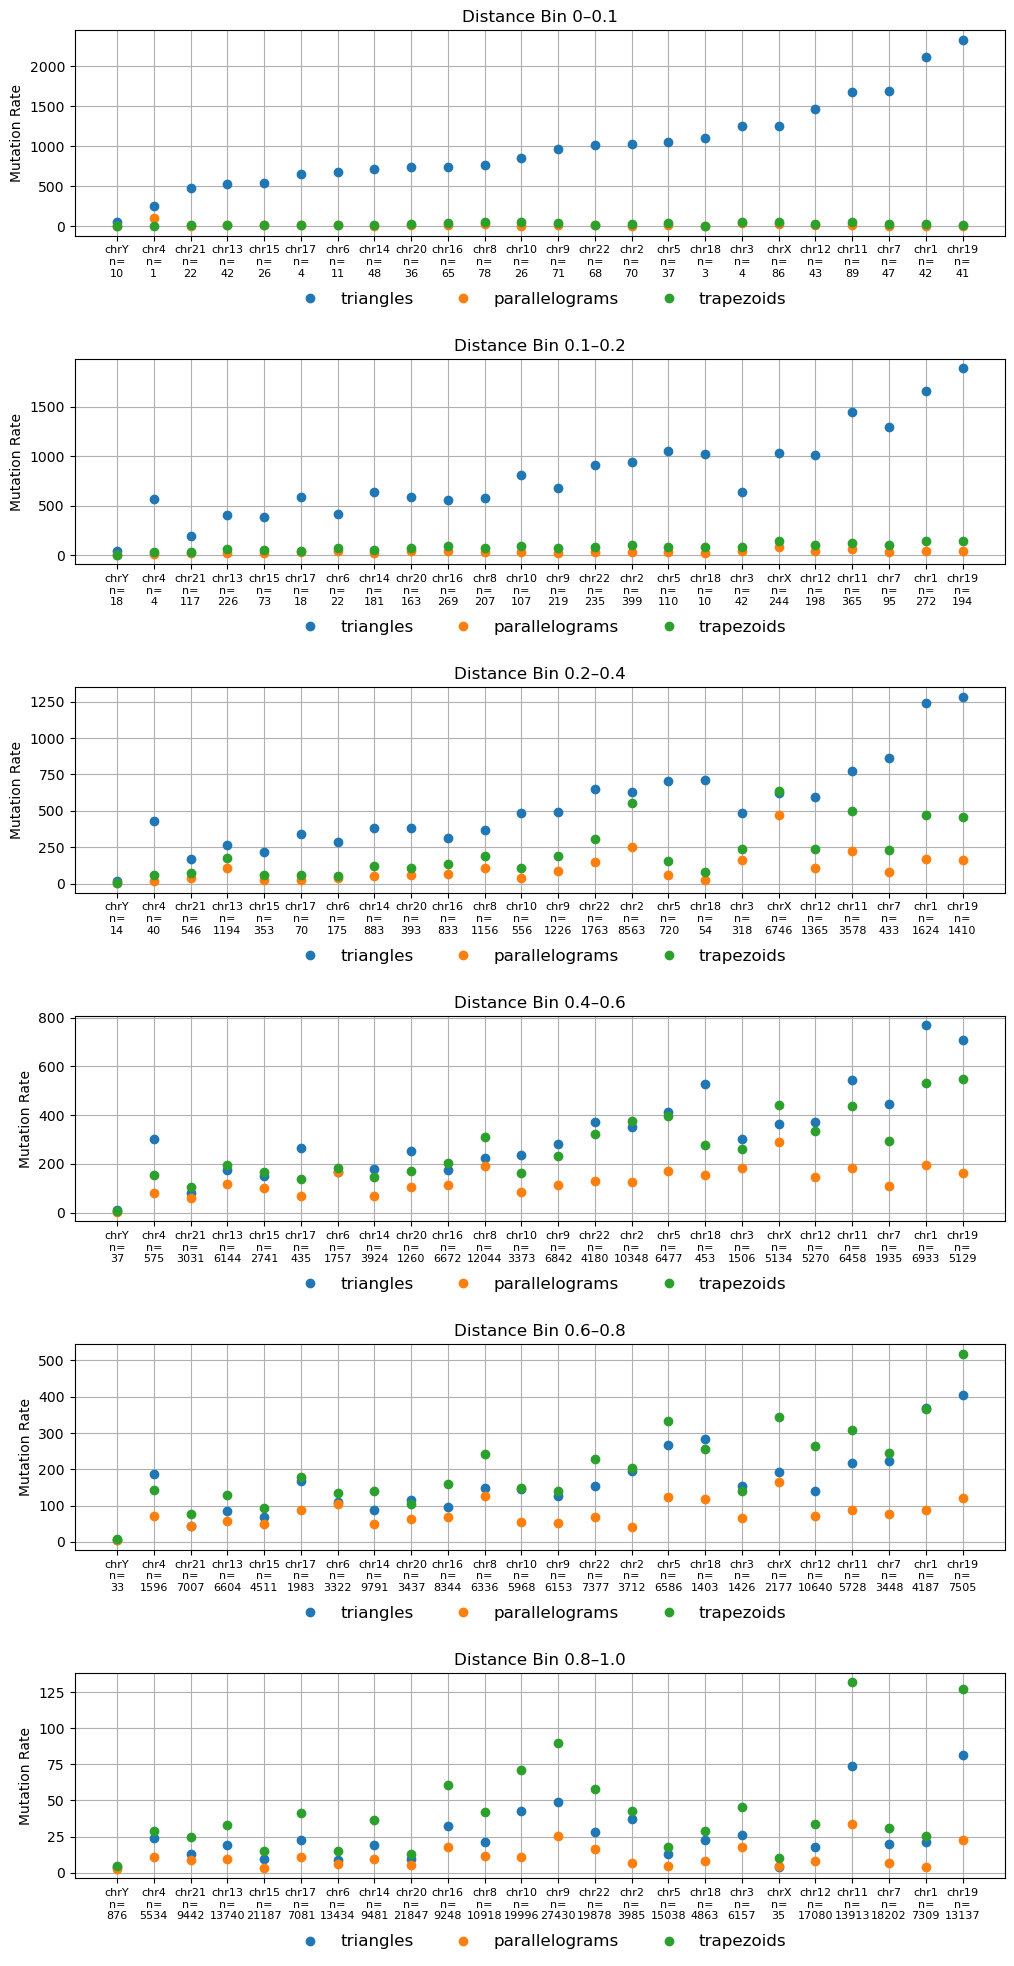

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import re

def chr_sort_key(chr_label):
    # Extract number after "chr" (works for chr1, chrX, chrM, etc.)
    match = re.match(r'chr(\d+)', chr_label)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # non-numeric chromosomes go at the end


shape_cols = mutation_rates_df["shape"].unique()
bins_order =  ["0–0.1", "0.1–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
chromosomes = sorted(mutation_rates_df["chr"].unique(), key=chr_sort_key)

n_bins = len(bins_order)
cols = 1  # number of columns per row
rows = (n_bins + cols - 1) // cols

# each plot twice as wide: 8 instead of 4
fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(12*cols, 4*rows),
    sharey=False,
    gridspec_kw={"hspace": 0.6}   # increase row spacing
)
axes = axes.flatten()

# --- Sort chromosomes by mutation rate in the 0-0.1 bin ---
# --- Sort chromosomes by triangle mutation rate in the 0-0.1 bin ---
bin0_df = mutation_rates_df[
    (mutation_rates_df["distance_bin"] == "0–0.1") &
    (mutation_rates_df["shape"] == "triangles")
].copy()

chromosomes = bin0_df.sort_values("mutation_rate", ascending=True)["chr"].tolist()

for i, bin_label in enumerate(bins_order):
    ax = axes[i]

    df_bin = mutation_rates_df[mutation_rates_df["distance_bin"] == bin_label].copy()
    if df_bin.empty:
        ax.axis('off')
        continue

    # Build lookup table: chromosome → n_rows
    n_lookup = (
        df_bin.groupby("chr")["n_rows"]
        .first()
        .reindex(chromosomes)
    )

    for shape in shape_cols:
        subset = df_bin[df_bin["shape"] == shape].copy()
        subset = subset[subset["chr"].isin(chromosomes)]
        subset = subset.set_index("chr").reindex(chromosomes)

        # Plot only markers (no connecting lines)
        ax.plot(
            subset.index.astype(str),
            subset["mutation_rate"],
            marker='o',
            linestyle='None',  # remove lines
            label=shape
        )

    # Create x tick labels: "chr12\nn=\n241"
    xtick_labels = [f"{chr_}\nn=\n{int(n_lookup[chr_])}" for chr_ in chromosomes]
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels(xtick_labels, rotation=0, fontsize=8)

    # Horizontal legend under the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(shape_cols),
        frameon=False,
        fontsize=12
    )
    ax.set_title(f"Distance Bin {bin_label}")
    ax.set_ylabel("Mutation Rate")
    ax.grid(True)


In [ ]:
## write num of SVs per pairwise comparison to an output csv file 

import pandas as pd

# Assuming your dataframe is called df
shape_cols = ["triangle", "parallelogram", "trapezoid"]

# Select columns for output
output_cols = ["sample1", "sample2", "chr"] + [f"{col}_mutation_rate" for col in shape_cols]
df_out = merged[output_cols]

# Write to CSV
df_out.to_csv("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/mutation_rates/mutation_rates_scaled.csv", index=False)


KeyError: "['triangle_mutation_rate', 'parallelogram_mutation_rate', 'trapezoid_mutation_rate'] not in index"

In [5]:
# read in alpha sat array sizes

import pandas as pd
import os

# Path to the folder containing TSV files
folder_path = "/private/groups/migalab/juklucas/censat_regions/active_arrays"

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files matching asat_arrays_${chr}.tsv, exclude ones with "_raw"
tsv_files = [f for f in all_files if f.startswith("asat_arrays_") and f.endswith(".tsv") and "_raw" not in f]

all_dfs = []

for tsv_file in tsv_files:
    # Extract chr from filename using string split
    # Example: "asat_arrays_chr12.tsv" -> "chr12"
    chr_label = tsv_file.replace("asat_arrays_", "").replace(".tsv", "")

    # Build full path
    file_path = os.path.join(folder_path, tsv_file)

    # Read TSV
    df = pd.read_csv(file_path, sep="\t")

    # Keep only desired columns
    df = df[["asat_start", "asat_end", "sample_id", "haplotype"]].copy()

    # Create combined haplotype.assembly_id column
    df["sample"] = df["sample_id"].astype(str) + "." + df["haplotype"].astype(str)

    # Add chr column from filename
    df["chr"] = chr_label

    all_dfs.append(df)

# Concatenate all files into a single DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True)

# Optional: keep only relevant columns
combined_df = combined_df[["asat_start", "asat_end", "sample", "chr"]]

print(combined_df.head())


   asat_start  asat_end     sample   chr
0    92070153  94778997  HG00097.1  chr2
1    92385520  94321652  HG00097.2  chr2
2    92130971  94547225  HG00099.1  chr2
3    92146667  94564932  HG00099.2  chr2
4    92601188  95044273  HG00126.1  chr2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re


# Step 0: Compute normalized mutation rates
# -----------------------------
# Compute average ASAT length per chromosome

avg_asat_length = combined_df.groupby("chr").apply(
    lambda df: (df["asat_end"] - df["asat_start"]).mean()
).to_dict()

# create new columns in merged df for normalized mutation rate 

mutation_rates_df["norm_mutation_rate"] = mutation_rates_df.apply(
    lambda row: row["mutation_rate"] / avg_asat_length[row["chr"]]
    if row["chr"] in avg_asat_length else np.nan,
    axis=1
)

mutation_rates_df.head()

/data/tmp/ipykernel_2109676/1194466320.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_asat_length = combined_df.groupby("chr").apply(


,chr,distance_bin,shape,mutation_rate,n_rows,norm_mutation_rate
0,chr1,0–0.1,triangles,2122.069476,42,0.000485
1,chr1,0–0.1,parallelograms,6.294193,42,0.000001
2,chr1,0–0.1,trapezoids,30.264890,42,0.000007
3,chr1,0.1–0.2,triangles,1657.294288,272,0.000379
4,chr1,0.1–0.2,parallelograms,37.982130,272,0.000009


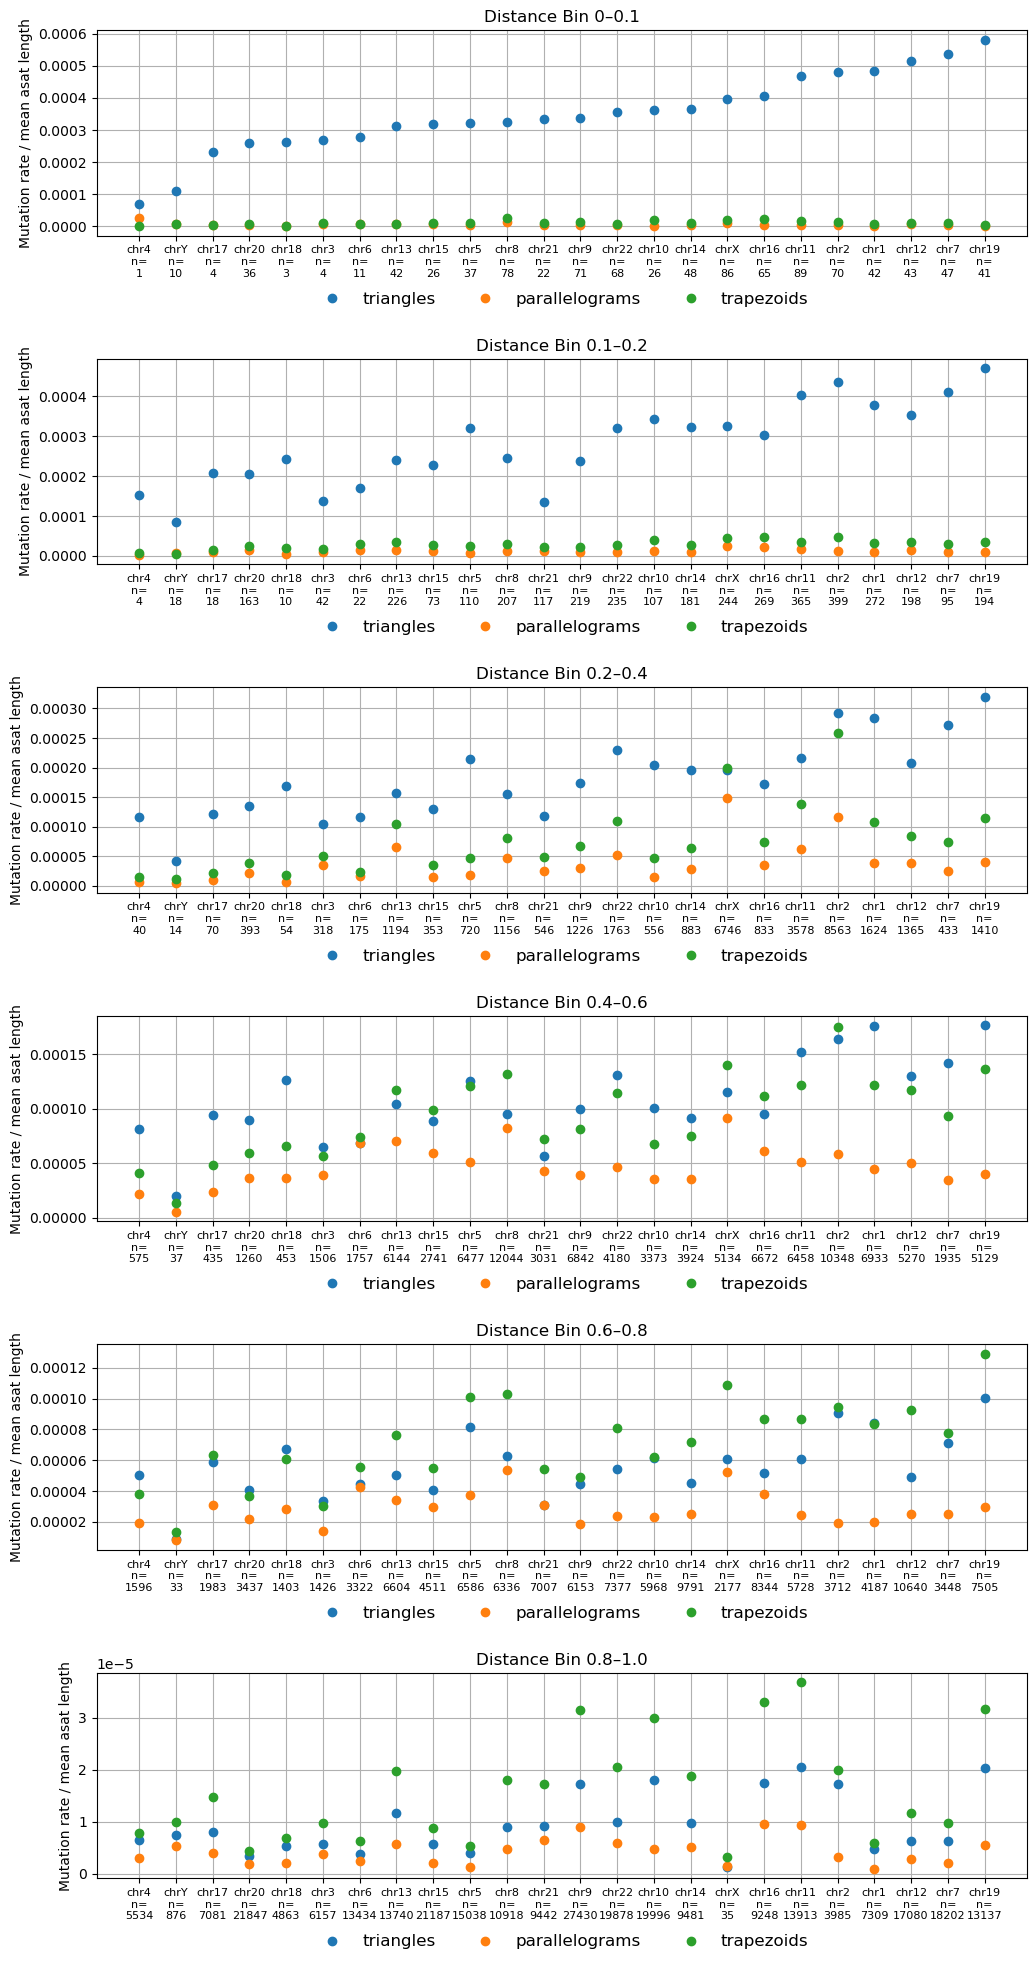

In [ ]:
## plot mutation rate normalized by array size
import matplotlib.pyplot as plt
import numpy as np

import re

def chr_sort_key(chr_label):
    # Extract number after "chr" (works for chr1, chrX, chrM, etc.)
    match = re.match(r'chr(\d+)', chr_label)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # non-numeric chromosomes go at the end


shape_cols = mutation_rates_df["shape"].unique()
bins_order =  ["0–0.1", "0.1–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
chromosomes = sorted(mutation_rates_df["chr"].unique(), key=chr_sort_key)

n_bins = len(bins_order)
cols = 1  # number of columns per row
rows = (n_bins + cols - 1) // cols

# each plot twice as wide: 8 instead of 4
fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(12*cols, 4*rows),
    sharey=False,
    gridspec_kw={"hspace": 0.6}   # increase row spacing
)
axes = axes.flatten()

# --- Sort chromosomes by mutation rate in the 0-0.1 bin ---
# --- Sort chromosomes by triangle mutation rate in the 0-0.1 bin ---
bin0_df = mutation_rates_df[
    (mutation_rates_df["distance_bin"] == "0–0.1") &
    (mutation_rates_df["shape"] == "triangles")
].copy()

chromosomes = bin0_df.sort_values("norm_mutation_rate", ascending=True)["chr"].tolist()

for i, bin_label in enumerate(bins_order):
    ax = axes[i]

    df_bin = mutation_rates_df[mutation_rates_df["distance_bin"] == bin_label].copy()
    if df_bin.empty:
        ax.axis('off')
        continue

    # Build lookup table: chromosome → n_rows
    n_lookup = (
        df_bin.groupby("chr")["n_rows"]
        .first()
        .reindex(chromosomes)
    )

    for shape in shape_cols:
        subset = df_bin[df_bin["shape"] == shape].copy()
        subset = subset[subset["chr"].isin(chromosomes)]
        subset = subset.set_index("chr").reindex(chromosomes)

        # Plot only markers (no connecting lines)
        ax.plot(
            subset.index.astype(str),
            subset["norm_mutation_rate"],
            marker='o',
            linestyle='None',  # remove lines
            label=shape
        )

    # Create x tick labels: "chr12\nn=\n241"
    xtick_labels = [f"{chr_}\nn=\n{int(n_lookup[chr_])}" for chr_ in chromosomes]
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels(xtick_labels, rotation=0, fontsize=8)

    # Horizontal legend under the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(shape_cols),
        frameon=False,
        fontsize=12
    )
    ax.set_title(f"Distance Bin {bin_label}")
    ax.set_ylabel("Mutation rate / mean asat length")
    ax.grid(True)

In [ ]:
# Add overlapping bins 

import pandas as pd
import numpy as np

# Define shapes
shape_cols = ["triangles", "parallelograms", "trapezoids"]

# Original bins
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.1", "0.1–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add overlapping bin 0–0.2
overlap_bins = [(0, 0.2)]
overlap_labels = ["0–0.2"]

results = []

for chr_id, df_chr in merged.groupby("chr"):
    df_chr = df_chr.copy()
    
    # Bin according to original bins
    df_chr["dp_bin"] = pd.cut(
        df_chr["direct_pairwise_dist"],
        bins=bins,
        labels=bin_labels,
        include_lowest=True
    )
    
    # Calculate mutation rates for original bins
    for bin_label in bin_labels:
        df_bin = df_chr[df_chr["dp_bin"] == bin_label]
        if df_bin.empty:
            continue
        for col in shape_cols:
            ratio = df_bin[col] / df_bin["patristic_dist"]
            mutation_rate = ratio.sum() / len(df_bin)
            results.append({
                "chr": chr_id,
                "distance_bin": bin_label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })
    
    # Calculate mutation rates for overlapping bins
    for (start, end), label in zip(overlap_bins, overlap_labels):
        df_bin = df_chr[(df_chr["direct_pairwise_dist"] >= start) & 
                        (df_chr["direct_pairwise_dist"] <= end)]
        if df_bin.empty:
            continue
        for col in shape_cols:
            ratio = df_bin[col] / df_bin["patristic_dist"]
            mutation_rate = ratio.sum() / len(df_bin)
            results.append({
                "chr": chr_id,
                "distance_bin": label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })

# Create DataFrame
mutation_rates_df = pd.DataFrame(results)

# Compute average ASAT length per chromosome

avg_asat_length = combined_df.groupby("chr").apply(
    lambda df: (df["asat_end"] - df["asat_start"]).mean()
).to_dict()

# create new columns in merged df for normalized mutation rate 

mutation_rates_df["norm_mutation_rate"] = mutation_rates_df.apply(
    lambda row: row["mutation_rate"] / avg_asat_length[row["chr"]]
    if row["chr"] in avg_asat_length else np.nan,
    axis=1
)

mutation_rates_df.head()

print(mutation_rates_df)


      chr distance_bin           shape  mutation_rate  n_rows  \
0    chr1        0–0.1       triangles    2122.069476      42   
1    chr1        0–0.1  parallelograms       6.294193      42   
2    chr1        0–0.1      trapezoids      30.264890      42   
3    chr1      0.1–0.2       triangles    1657.294288     272   
4    chr1      0.1–0.2  parallelograms      37.982130     272   
..    ...          ...             ...            ...     ...   
499  chrY      0.8–1.0  parallelograms       2.692159     876   
500  chrY      0.8–1.0      trapezoids       5.048369     876   
501  chrY        0–0.2       triangles      47.327574      28   
502  chrY        0–0.2  parallelograms       3.303115      28   
503  chrY        0–0.2      trapezoids       2.571479      28   

     norm_mutation_rate  
0              0.000485  
1              0.000001  
2              0.000007  
3              0.000379  
4              0.000009  
..                  ...  
499            0.000005  
500        

/data/tmp/ipykernel_2109676/3219273954.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_asat_length = combined_df.groupby("chr").apply(


['0–0.1' '0.1–0.2' '0.2–0.4' '0.4–0.6' '0.6–0.8' '0.8–1.0' '0–0.2']


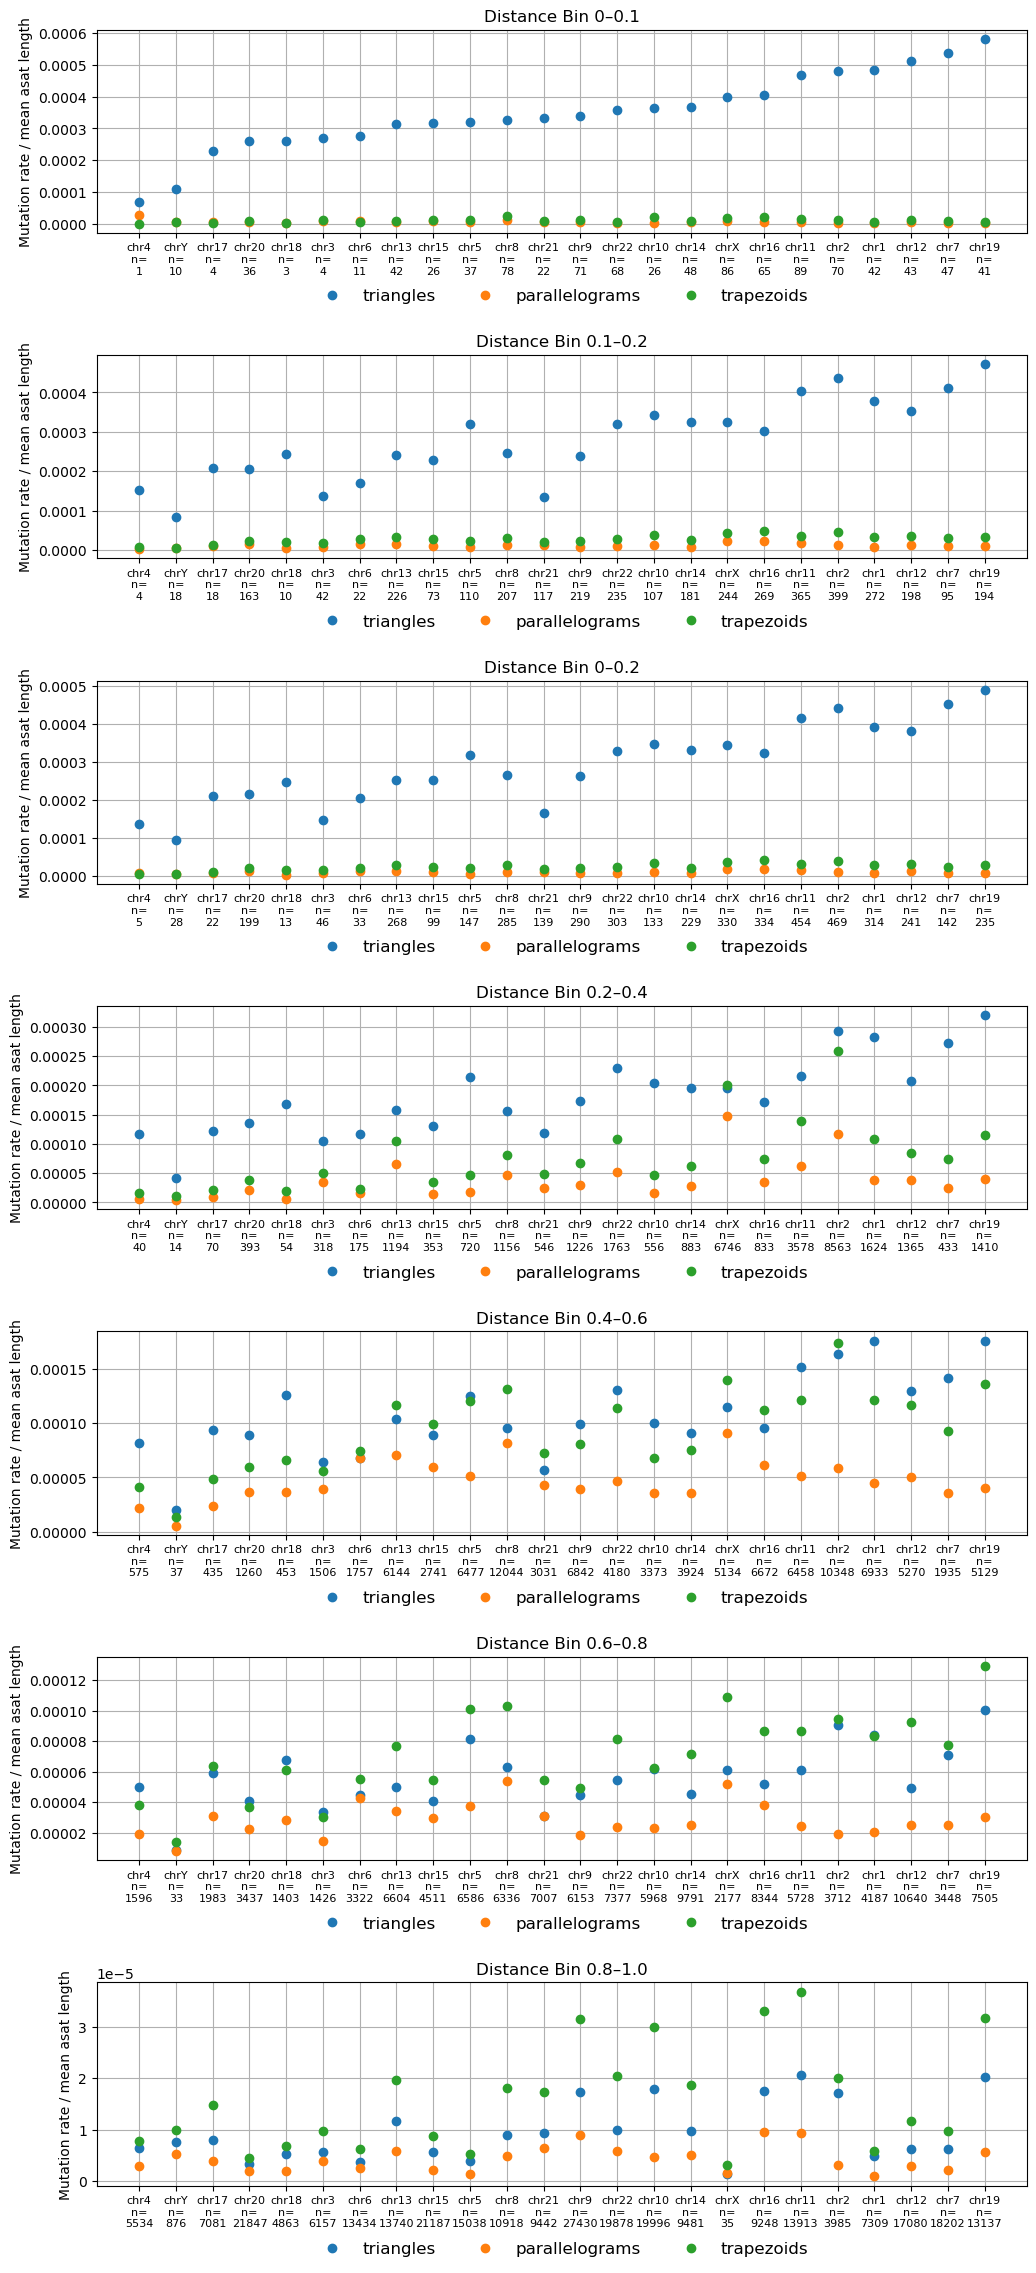

In [ ]:
# PLot overlapping bins
import matplotlib.pyplot as plt
import numpy as np

import re

def chr_sort_key(chr_label):
    # Extract number after "chr" (works for chr1, chrX, chrM, etc.)
    match = re.match(r'chr(\d+)', chr_label)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # non-numeric chromosomes go at the end


shape_cols = mutation_rates_df["shape"].unique()
bins_order = ["0–0.1", "0.1–0.2", "0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
chromosomes = sorted(mutation_rates_df["chr"].unique(), key=chr_sort_key)

print(mutation_rates_df["distance_bin"].unique())


n_bins = len(bins_order)
cols = 1  # number of columns per row
rows = (n_bins + cols - 1) // cols

# each plot twice as wide: 8 instead of 4
fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(12*cols, 4*rows),
    sharey=False,
    gridspec_kw={"hspace": 0.6}   # increase row spacing
)
axes = axes.flatten()

# --- Sort chromosomes by mutation rate in the 0-0.1 bin ---
# --- Sort chromosomes by triangle mutation rate in the 0-0.1 bin ---
bin0_df = mutation_rates_df[
    (mutation_rates_df["distance_bin"] == "0–0.1") &
    (mutation_rates_df["shape"] == "triangles")
].copy()

chromosomes = bin0_df.sort_values("norm_mutation_rate", ascending=True)["chr"].tolist()

for i, bin_label in enumerate(bins_order):
    ax = axes[i]

    df_bin = mutation_rates_df[mutation_rates_df["distance_bin"] == bin_label].copy()
    if df_bin.empty:
        ax.axis('off')
        continue

    # Build lookup table: chromosome → n_rows
    n_lookup = (
        df_bin.groupby("chr")["n_rows"]
        .first()
        .reindex(chromosomes)
    )

    for shape in shape_cols:
        subset = df_bin[df_bin["shape"] == shape].copy()
        subset = subset[subset["chr"].isin(chromosomes)]
        subset = subset.set_index("chr").reindex(chromosomes)

        # Plot only markers (no connecting lines)
        ax.plot(
            subset.index.astype(str),
            subset["norm_mutation_rate"],
            marker='o',
            linestyle='None',  # remove lines
            label=shape
        )

    # Create x tick labels: "chr12\nn=\n241"
    xtick_labels = [f"{chr_}\nn=\n{int(n_lookup[chr_])}" for chr_ in chromosomes]
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels(xtick_labels, rotation=0, fontsize=8)

    # Horizontal legend under the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(shape_cols),
        frameon=False,
        fontsize=12
    )
    ax.set_title(f"Distance Bin {bin_label}")
    ax.set_ylabel("Mutation rate / mean asat length")
    ax.grid(True)

In [8]:
### Scatterplot of patristic distance in the HOR tree versus cenhap patristic distance 

chrom_to_file = {"chr11": "/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/tree_pair_dist/cenhap_12042025/HPRC_chr11_50650000_51023358_54476419_54808189_het449_m_final_dgp_upgma.pair_dists.tsv",
"chr12":"/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/tree_pair_dist/cenhap_12042025/HPRC_chr12_34544731_34593492_37202490_37285321_het60_m_hprc_dgp_rnj_upgma.pair_dists.tsv",
"chr17": "/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/tree_pair_dist/cenhap_12042025/HPRC_chr17_23278614_23433372_27571319_27700000_het114_m_hprc_dgp_upgma.pair_dists.tsv",
"chr6": "/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/tree_pair_dist/cenhap_12042025/HPRC_chr6_58200000_58286706_61058390_61123742_het70_m_hprc_dgp_rnj_upgma.pair_dists.tsv"}

dfs = []

for chrom, filepath in chrom_to_file.items():
    df = pd.read_csv(filepath, sep="\t")  # header is present
    df = df.rename(columns={
        df.columns[0]: "sample1",
        df.columns[1]: "sample2",
        df.columns[2]: "cenhap_pat_dist"
    })
    df["chr"] = chrom
    dfs.append(df)

cenhap_pat_df = pd.concat(dfs, ignore_index=True)

cenhap_pat_df.head()


,sample1,sample2,cenhap_pat_dist,chr
0,NA20129.2,NA21106.1,0.000054,chr11
1,NA20129.2,NA20827.1,0.000086,chr11
2,NA20129.2,HG01346.1,0.000086,chr11
3,NA20129.2,HG00290.1,0.000086,chr11
4,NA20129.2,HG01433.2,0.000086,chr11


In [ ]:
def canonicalize_pair(df):
    df = df.copy()
    df[["s1_c", "s2_c"]] = (
        df[["sample1", "sample2"]]
        .apply(lambda row: sorted(row), axis=1, result_type="expand")
    )
    return df

cenhap_c = canonicalize_pair(cenhap_pat_df)
hor_c = canonicalize_pair(patristic_dist_df)

merged = cenhap_c.merge(
    hor_c[["s1_c", "s2_c", "chr", "patristic_dist"]],
    on=["s1_c", "s2_c", "chr"],
    how="left"   # combined has fewer rows, as you requested
)



dist_df_c=canonicalize_pair(dist_df)

merged2 = merged.merge(
    dist_df_c[["s1_c", "s2_c", "chr", "direct_pairwise_dist"]],
    on=["s1_c", "s2_c", "chr"],
    how="left"   # combined has fewer rows, as you requested
)

In [ ]:
merged2.head()

,sample1,sample2,cenhap_pat_dist,chr,s1_c,s2_c,patristic_dist,direct_pairwise_dist
0,NA20129.2,NA21106.1,0.000054,chr11,NA20129.2,NA21106.1,0.571685,0.587177
1,NA20129.2,NA20827.1,0.000086,chr11,NA20129.2,NA20827.1,0.451014,0.446617
2,NA20129.2,HG01346.1,0.000086,chr11,HG01346.1,NA20129.2,0.451064,0.468090
3,NA20129.2,HG00290.1,0.000086,chr11,HG00290.1,NA20129.2,0.450947,0.441649
4,NA20129.2,HG01433.2,0.000086,chr11,HG01433.2,NA20129.2,0.450996,0.443828


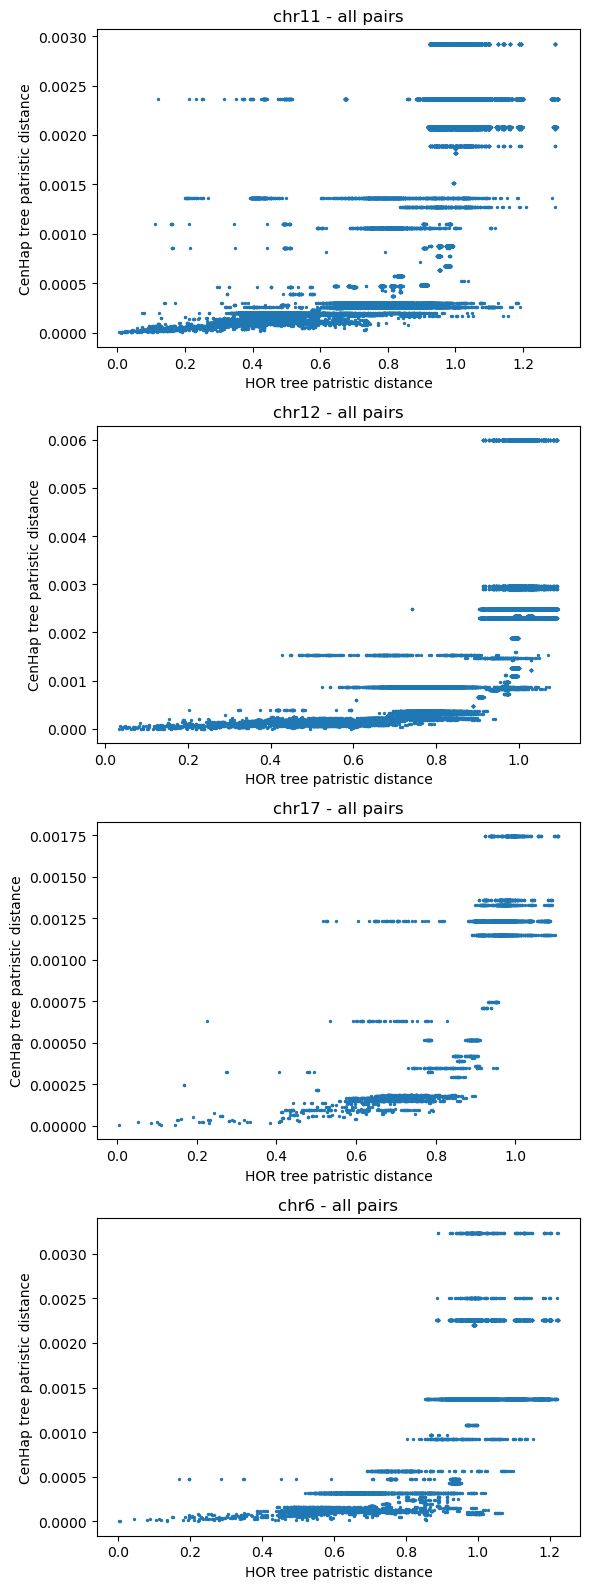

In [ ]:
import matplotlib.pyplot as plt

# assume your dataframe is called df

# get the unique chromosomes
chromosomes = merged['chr'].unique()

# set up one subplot per chromosome
fig, axes = plt.subplots(nrows=len(chromosomes), ncols=1, figsize=(6, 4*len(chromosomes)))

# if only one chromosome, axes is not a list
if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    sub = merged[merged['chr'] == chrom]

    ax.scatter(sub['patristic_dist'], sub['cenhap_pat_dist'], s=2)
    ax.set_title(f"{chrom} - all pairs")
    ax.set_xlabel("HOR tree patristic distance")
    ax.set_ylabel("CenHap tree patristic distance")

plt.tight_layout()
plt.show()


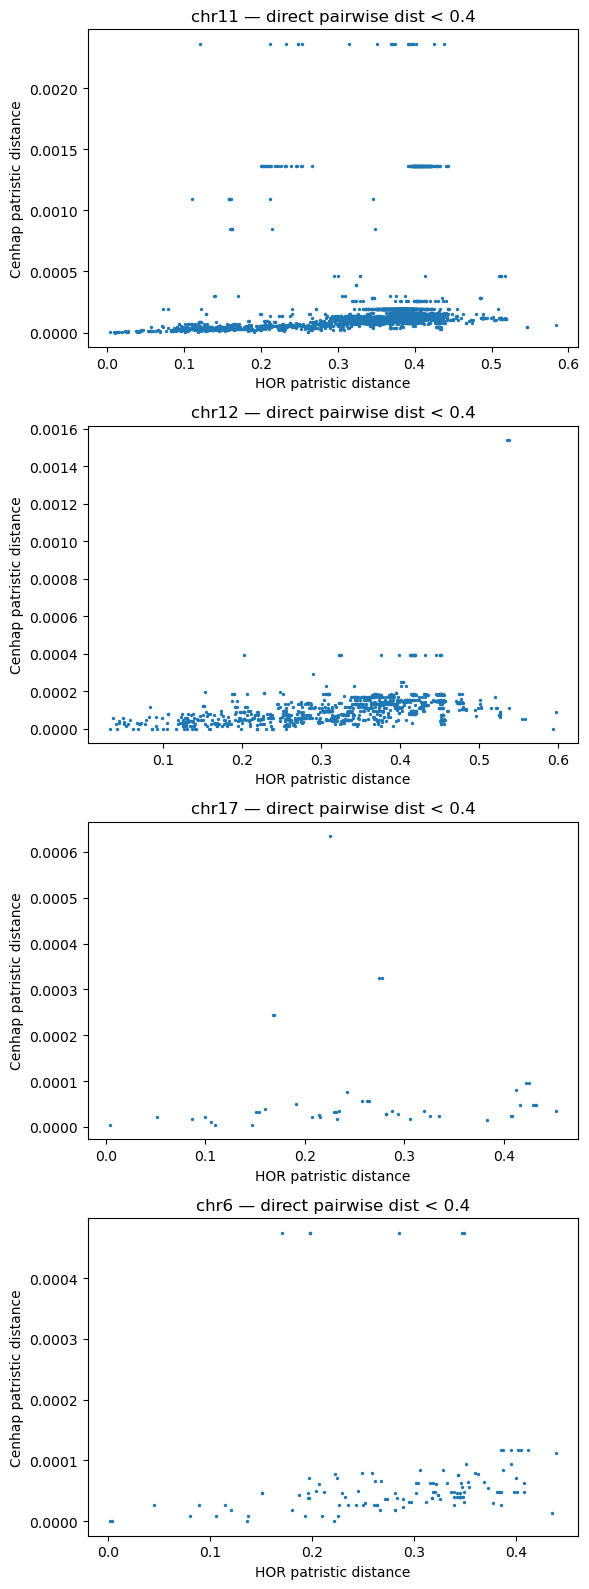

In [ ]:
df_filt = merged2[merged2['direct_pairwise_dist'] < 0.4]

fig, axes = plt.subplots(nrows=len(chromosomes), ncols=1,
                         figsize=(6, 4 * len(chromosomes)))

if len(chromosomes) == 1:
    axes = [axes]

for ax, chrom in zip(axes, chromosomes):
    sub = df_filt[df_filt['chr'] == chrom]

    ax.scatter(sub['patristic_dist'],
               sub['cenhap_pat_dist'],
               s=2)
    ax.set_title(f"{chrom} — direct pairwise dist < 0.4")
    ax.set_xlabel("HOR patristic distance")
    ax.set_ylabel("Cenhap patristic distance")

plt.tight_layout()
plt.show()

In [6]:
## Read in SNP distances
path = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/SNP_based_distances/"   # change to your directory

files = glob.glob(os.path.join(
    path,
    "*_r2_QC_v2_centrolign_pairwise_distance.csv"
))

dfs = []

for f in files:
    # extract chromosome name from filename
    base = os.path.basename(f)
    chr_name = base.split("_")[0]

    # read the tsv file (tab-separated)
    df = pd.read_csv(f, header=None, names=["sample1","sample2","snp_dist"])

    # add chr column
    df["chr"] = chr_name

    dfs.append(df)

# combine all files
snp_dist_df = pd.concat(dfs, ignore_index=True)
snp_dist_df.columns = ["sample1", "sample2", "snp_dist","chr"]
print(snp_dist_df)

           sample1    sample2  snp_dist   chr
0        HG03098.1  HG03784.1  0.007934  chr6
1        HG03098.1  NA20752.2  0.014866  chr6
2        HG01978.2  NA19835.1  0.006349  chr6
3        HG00741.1  NA18522.1  0.007092  chr6
4        HG00408.1  HG01496.1  0.001038  chr6
...            ...        ...       ...   ...
1132390  HG03471.2  NA18508.1  0.028102  chr5
1132391  HG02615.1  NA18948.1  0.020000  chr5
1132392  HG01891.1  NA19776.2  0.013699  chr5
1132393  HG00126.1  NA20827.1  0.000856  chr5
1132394  HG01150.2  HG01786.1  0.001502  chr5

[1132395 rows x 4 columns]


In [9]:
# Merge SVs and distances 

def sort_samples(df):
    df = df.copy()
    df[["s1","s2"]] = (
        df[["sample1", "sample2"]]
        .apply(lambda x: sorted(x), axis=1, result_type="expand")
    )
    return df

all_df_c = sort_samples(all_df)
dist_df_c = sort_samples(dist_df)
snp_dist_df_c = sort_samples(snp_dist_df)
cenhap_pat_df_c = sort_samples(cenhap_pat_df)

# Drop the sample1/sample2 columns from the dataframes being merged in
dist_df_c = dist_df_c.drop(columns=["sample1", "sample2"])
snp_dist_df_c  = snp_dist_df_c.drop(columns=["sample1", "sample2"])
cenhap_pat_df_c = cenhap_pat_df_c.drop(columns=["sample1", "sample2"])

# merge dataframes 
merged = (
    all_df_c
    .merge(dist_df_c, on=["s1", "s2", "chr"], how="left")
    .merge(snp_dist_df_c, on=["s1", "s2", "chr"], how="left")
    .merge(cenhap_pat_df_c, on=["s1", "s2", "chr"], how="left")
)

merged = merged.drop(columns=["s1", "s2"])
print(merged)

          sample1    sample2  triangles  parallelograms  trapezoids    chr  \
0       HG00099.2    HG002.2        212             104         212   chr5   
1       HG00099.2  HG00558.2        206             104         210   chr5   
2       HG00099.2  HG00597.2        240             112         230   chr5   
3       HG00099.2  HG00609.2        244             110         232   chr5   
4       HG00099.2  HG00658.1        226             100         221   chr5   
...           ...        ...        ...             ...         ...    ...   
550509  NA21110.2  NA20805.1         93             140         133  chr16   
550510  NA21110.2  NA20805.2        138              70          91  chr16   
550511  NA21110.2  NA20806.2        106              14          34  chr16   
550512  NA21110.2  NA21093.1          7               6           9  chr16   
550513  NA21110.2  NA21106.2        100             132         146  chr16   

                subgroup  direct_pairwise_dist  snp_dist  cenha

In [11]:
# calculate mutation rates from snps
import pandas as pd
import numpy as np

# Define shapes
shape_cols = ["triangles", "parallelograms", "trapezoids"]

# Original bins
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.1", "0.1–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add overlapping bin 0–0.2
overlap_bins = [(0, 0.2)]
overlap_labels = ["0–0.2"]

results = []

for chr_id, df_chr in merged.groupby("chr"):
    df_chr = df_chr.copy()
    
    # Bin according to original bins
    df_chr["dp_bin"] = pd.cut(
        df_chr["direct_pairwise_dist"],
        bins=bins,
        labels=bin_labels,
        include_lowest=True
    )
    
    # Calculate mutation rates for original bins
    for bin_label in bin_labels:
        df_bin = df_chr[df_chr["dp_bin"] == bin_label]
        if df_bin.empty:
            continue
        for col in shape_cols:
            ratio = df_bin[col] / df_bin["snp_dist"]
            mutation_rate = ratio.sum() / len(df_bin)
            results.append({
                "chr": chr_id,
                "distance_bin": bin_label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })
    
    # Calculate mutation rates for overlapping bins
    for (start, end), label in zip(overlap_bins, overlap_labels):
        df_bin = df_chr[(df_chr["direct_pairwise_dist"] >= start) & 
                        (df_chr["direct_pairwise_dist"] <= end)]
        if df_bin.empty:
            continue
        for col in shape_cols:
            ratio = df_bin[col] / df_bin["snp_dist"]
            mutation_rate = ratio.sum() / len(df_bin)
            results.append({
                "chr": chr_id,
                "distance_bin": label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })

# Create DataFrame
mutation_rates_df_snps = pd.DataFrame(results)

# Compute average ASAT length per chromosome

avg_asat_length = combined_df.groupby("chr").apply(
    lambda df: (df["asat_end"] - df["asat_start"]).mean()
).to_dict()

# create new columns in merged df for normalized mutation rate 

mutation_rates_df_snps["norm_mutation_rate"] = mutation_rates_df_snps.apply(
    lambda row: row["mutation_rate"] / avg_asat_length[row["chr"]]
    if row["chr"] in avg_asat_length else np.nan,
    axis=1
)

mutation_rates_df_snps.head()

print(mutation_rates_df_snps)

      chr distance_bin           shape  mutation_rate  n_rows  \
0    chr1        0–0.1       triangles  586692.496771      42   
1    chr1        0–0.1  parallelograms    1774.513943      42   
2    chr1        0–0.1      trapezoids    8435.260851      42   
3    chr1      0.1–0.2       triangles  406105.971995     272   
4    chr1      0.1–0.2  parallelograms    8799.465596     272   
..    ...          ...             ...            ...     ...   
499  chrY      0.8–1.0  parallelograms    6891.764889     876   
500  chrY      0.8–1.0      trapezoids   13639.768264     876   
501  chrY        0–0.2       triangles   50913.241732      28   
502  chrY        0–0.2  parallelograms   14562.912365      28   
503  chrY        0–0.2      trapezoids    7333.768293      28   

     norm_mutation_rate  
0              0.134178  
1              0.000406  
2              0.001929  
3              0.092877  
4              0.002012  
..                  ...  
499            0.013699  
500        

/data/tmp/ipykernel_2399310/3441710416.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_asat_length = combined_df.groupby("chr").apply(


['0–0.1' '0.1–0.2' '0.2–0.4' '0.4–0.6' '0.6–0.8' '0.8–1.0' '0–0.2']


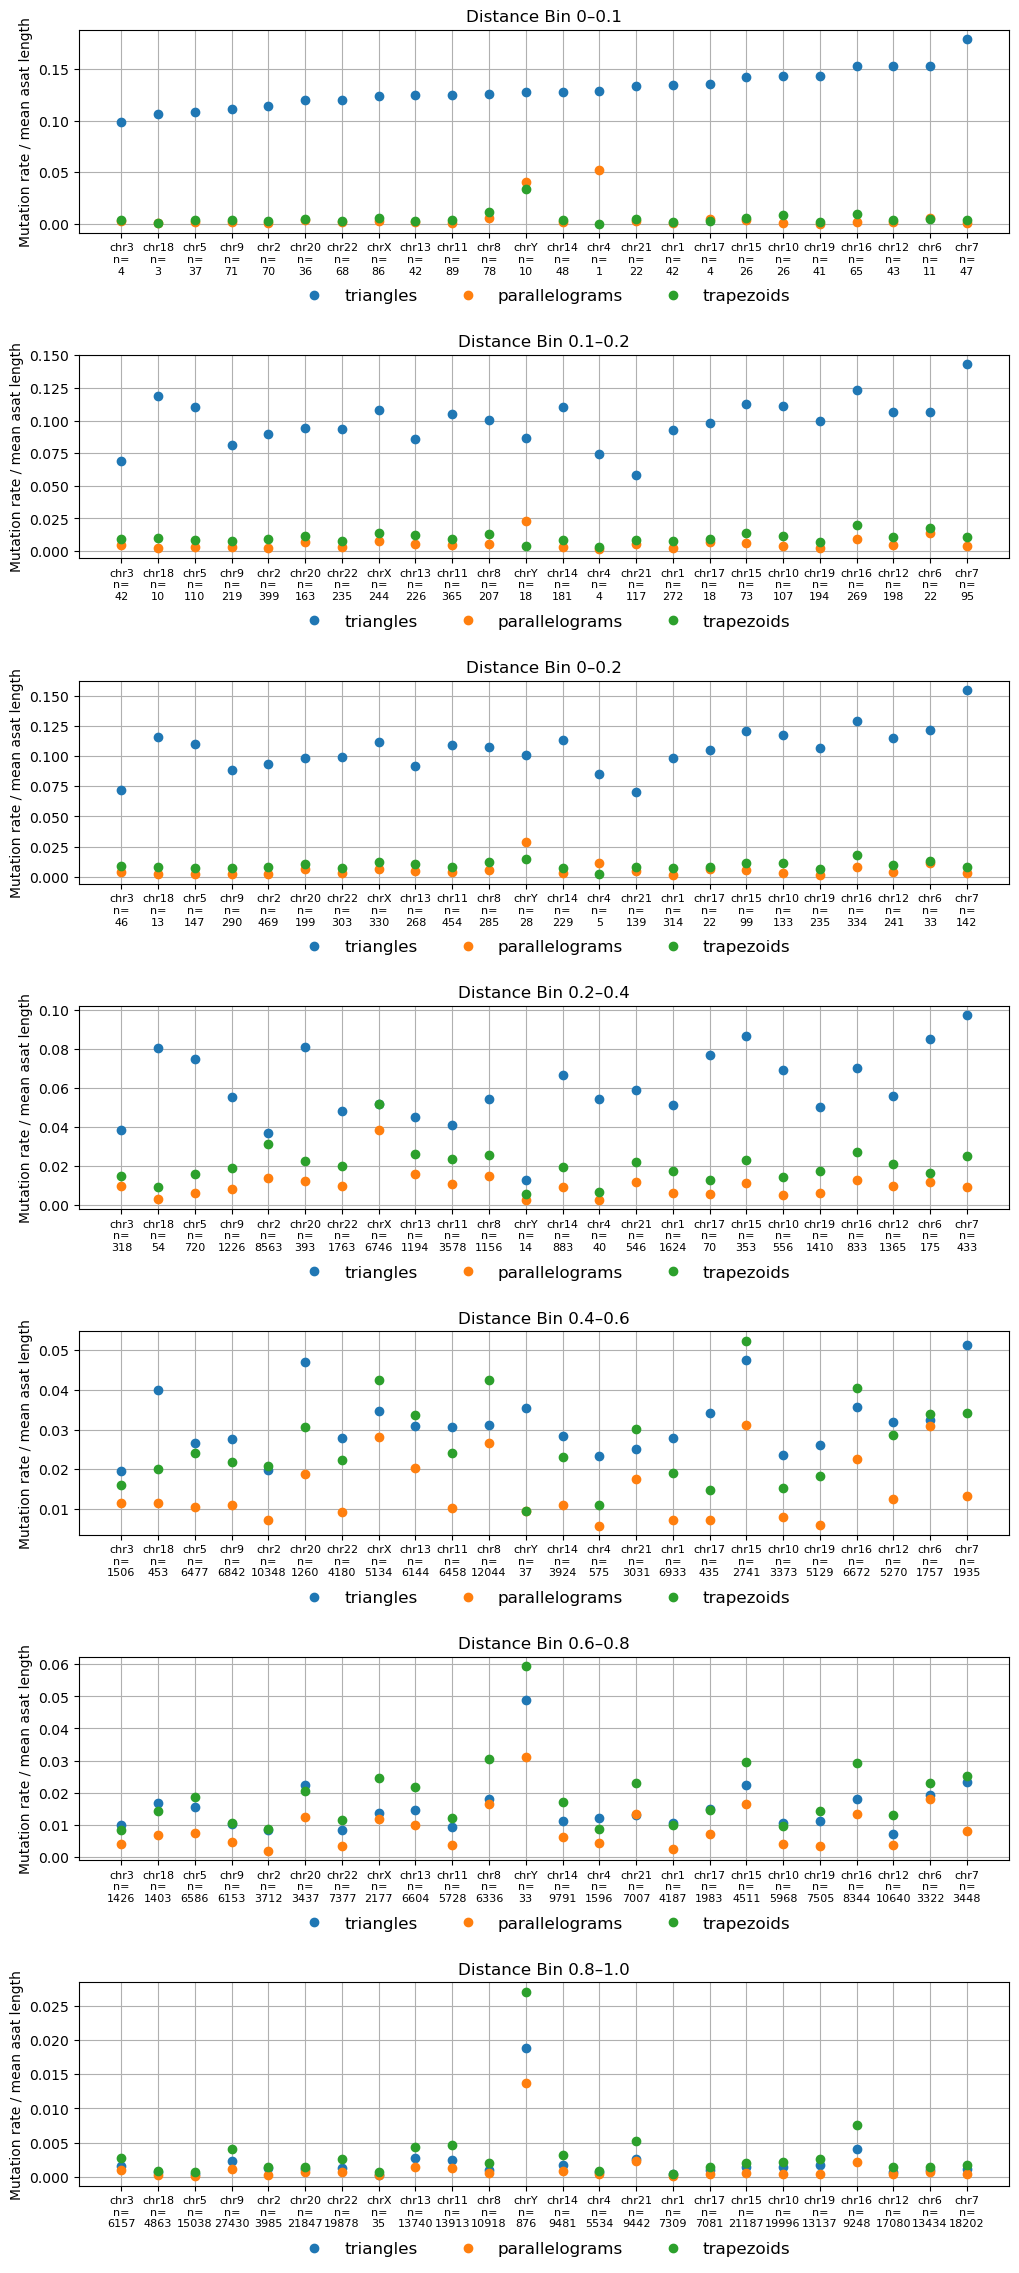

In [12]:
### Plot mutation rates using SNP distances 

import matplotlib.pyplot as plt
import numpy as np

import re

def chr_sort_key(chr_label):
    # Extract number after "chr" (works for chr1, chrX, chrM, etc.)
    match = re.match(r'chr(\d+)', chr_label)
    if match:
        return int(match.group(1))
    else:
        return float('inf')  # non-numeric chromosomes go at the end


shape_cols = mutation_rates_df_snps["shape"].unique()
bins_order = ["0–0.1", "0.1–0.2", "0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
chromosomes = sorted(mutation_rates_df_snps["chr"].unique(), key=chr_sort_key)

print(mutation_rates_df_snps["distance_bin"].unique())


n_bins = len(bins_order)
cols = 1  # number of columns per row
rows = (n_bins + cols - 1) // cols

# each plot twice as wide: 8 instead of 4
fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(12*cols, 4*rows),
    sharey=False,
    gridspec_kw={"hspace": 0.6}   # increase row spacing
)
axes = axes.flatten()

# --- Sort chromosomes by mutation rate in the 0-0.1 bin ---
# --- Sort chromosomes by triangle mutation rate in the 0-0.1 bin ---
bin0_df = mutation_rates_df_snps[
    (mutation_rates_df_snps["distance_bin"] == "0–0.1") &
    (mutation_rates_df_snps["shape"] == "triangles")
].copy()

chromosomes = bin0_df.sort_values("norm_mutation_rate", ascending=True)["chr"].tolist()

for i, bin_label in enumerate(bins_order):
    ax = axes[i]

    df_bin = mutation_rates_df_snps[mutation_rates_df_snps["distance_bin"] == bin_label].copy()
    if df_bin.empty:
        ax.axis('off')
        continue

    # Build lookup table: chromosome → n_rows
    n_lookup = (
        df_bin.groupby("chr")["n_rows"]
        .first()
        .reindex(chromosomes)
    )

    for shape in shape_cols:
        subset = df_bin[df_bin["shape"] == shape].copy()
        subset = subset[subset["chr"].isin(chromosomes)]
        subset = subset.set_index("chr").reindex(chromosomes)

        # Plot only markers (no connecting lines)
        ax.plot(
            subset.index.astype(str),
            subset["norm_mutation_rate"],
            marker='o',
            linestyle='None',  # remove lines
            label=shape
        )

    # Create x tick labels: "chr12\nn=\n241"
    xtick_labels = [f"{chr_}\nn=\n{int(n_lookup[chr_])}" for chr_ in chromosomes]
    ax.set_xticks(range(len(chromosomes)))
    ax.set_xticklabels(xtick_labels, rotation=0, fontsize=8)

    # Horizontal legend under the plot
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=len(shape_cols),
        frameon=False,
        fontsize=12
    )
    ax.set_title(f"Distance Bin {bin_label}")
    ax.set_ylabel("Mutation rate / mean asat length")
    ax.grid(True)

In [ ]:
# calculate mutation rates with cenhap distances too 

import pandas as pd
import numpy as np

# Define shapes
shape_cols = ["triangles", "parallelograms", "trapezoids"]

# Original bins
bins = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.1", "0.1–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add overlapping bin 0–0.2
overlap_bins = [(0, 0.2)]
overlap_labels = ["0–0.2"]

results = []

for chr_id, df_chr in merged.groupby("chr"):
    df_chr = df_chr.copy()
    
    # Bin according to original bins
    df_chr["dp_bin"] = pd.cut(
        df_chr["direct_pairwise_dist"],
        bins=bins,
        labels=bin_labels,
        include_lowest=True
    )
    
    # Calculate mutation rates for original bins
    for bin_label in bin_labels:
        df_bin = df_chr[df_chr["dp_bin"] == bin_label]
        if df_bin.empty:
            continue
        for col in shape_cols:
            ratio = df_bin[col] / df_bin["cenhap_pat_dist"]
            mutation_rate = ratio.sum() / len(df_bin)
            results.append({
                "chr": chr_id,
                "distance_bin": bin_label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })
    
    # Calculate mutation rates for overlapping bins
    for (start, end), label in zip(overlap_bins, overlap_labels):
        df_bin = df_chr[(df_chr["direct_pairwise_dist"] >= start) & 
                        (df_chr["direct_pairwise_dist"] <= end)]
        if df_bin.empty:
            continue
        for col in shape_cols:
            ratio = df_bin[col] / df_bin["cenhap_pat_dist"]
            mutation_rate = ratio.sum() / len(df_bin)
            results.append({
                "chr": chr_id,
                "distance_bin": label,
                "shape": col,
                "mutation_rate": mutation_rate,
                "n_rows": len(df_bin)
            })

# Create DataFrame
mutation_rates_df_cenhaps = pd.DataFrame(results)

# Compute average ASAT length per chromosome

avg_asat_length = combined_df.groupby("chr").apply(
    lambda df: (df["asat_end"] - df["asat_start"]).mean()
).to_dict()

# create new columns in merged df for normalized mutation rate 

mutation_rates_df_cenhaps["norm_mutation_rate"] = mutation_rates_df_cenhaps.apply(
    lambda row: row["mutation_rate"] / avg_asat_length[row["chr"]]
    if row["chr"] in avg_asat_length else np.nan,
    axis=1
)

mutation_rates_df_cenhaps.head()

print(mutation_rates_df_cenhaps)

      chr distance_bin           shape  mutation_rate  n_rows  \
0    chr1        0–0.1       triangles            0.0      42   
1    chr1        0–0.1  parallelograms            0.0      42   
2    chr1        0–0.1      trapezoids            0.0      42   
3    chr1      0.1–0.2       triangles            0.0     272   
4    chr1      0.1–0.2  parallelograms            0.0     272   
..    ...          ...             ...            ...     ...   
499  chrY      0.8–1.0  parallelograms            0.0     876   
500  chrY      0.8–1.0      trapezoids            0.0     876   
501  chrY        0–0.2       triangles            0.0      28   
502  chrY        0–0.2  parallelograms            0.0      28   
503  chrY        0–0.2      trapezoids            0.0      28   

     norm_mutation_rate  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
..                  ...  
499                 0.0  
500        

/data/tmp/ipykernel_2109676/3855270521.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_asat_length = combined_df.groupby("chr").apply(


In [ ]:
# compare mutation rate calculated with snp distance vs mutation rate calculated with tree patristic distance
merged_snp_hor = (
    mutation_rates_df.merge(mutation_rates_df_snps, on=["chr", "distance_bin", "shape","n_rows"], how="left")
    .merge(mutation_rates_df_cenhaps, on=["chr", "distance_bin", "shape","n_rows"], how="left")
) 

merged_snp_hor.head()

,chr,distance_bin,shape,mutation_rate_x,n_rows,norm_mutation_rate_x,mutation_rate_y,norm_mutation_rate_y,mutation_rate,norm_mutation_rate
0,chr1,0–0.1,triangles,2122.069476,42,0.000485,586692.496771,0.134178,0.0,0.0
1,chr1,0–0.1,parallelograms,6.294193,42,0.000001,1774.513943,0.000406,0.0,0.0
2,chr1,0–0.1,trapezoids,30.264890,42,0.000007,8435.260851,0.001929,0.0,0.0
3,chr1,0.1–0.2,triangles,1657.294288,272,0.000379,406105.971995,0.092877,0.0,0.0
4,chr1,0.1–0.2,parallelograms,37.982130,272,0.000009,8799.465596,0.002012,0.0,0.0


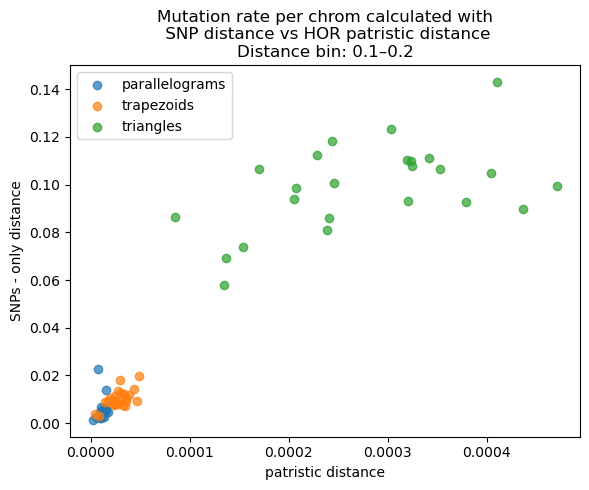

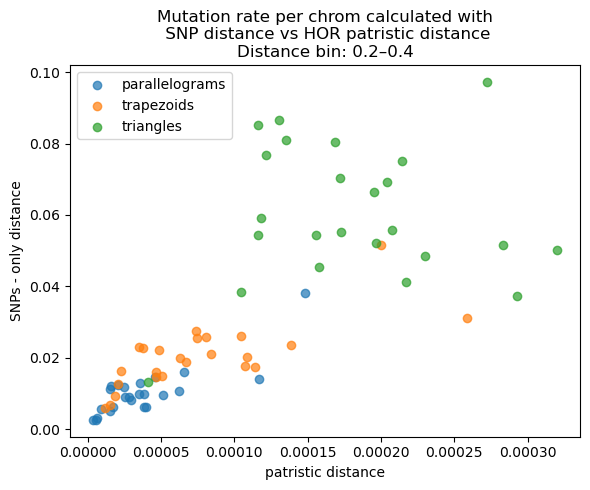

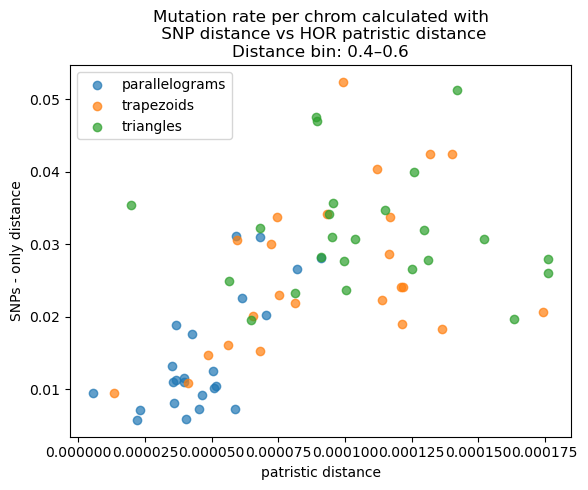

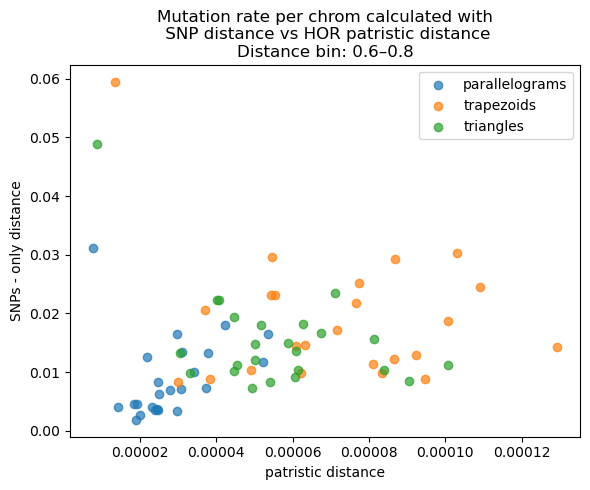

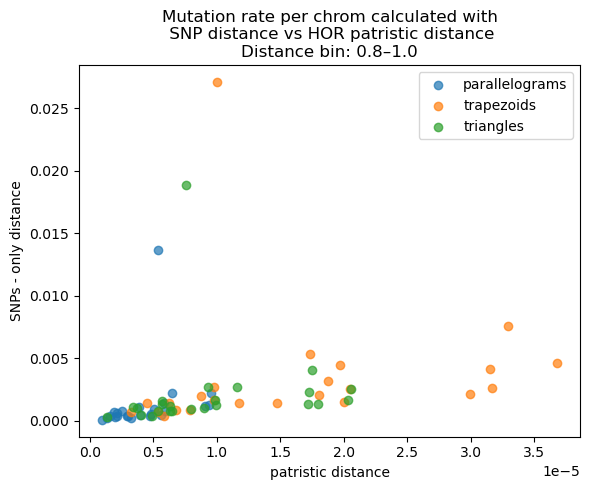

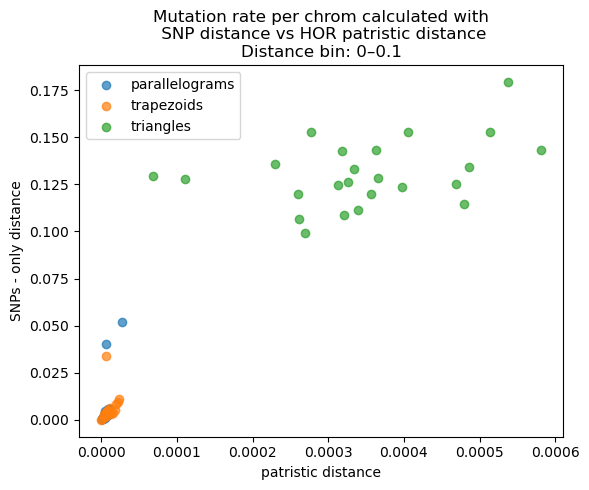

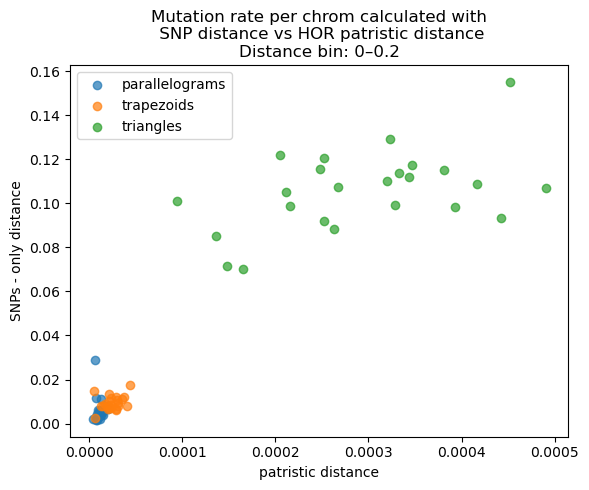

In [ ]:
import matplotlib.pyplot as plt

# Unique distance bins and shapes

df=merged_snp_hor.copy()
bins = sorted(df["distance_bin"].unique())
shapes = sorted(df["shape"].unique())

# Assign a color to each shape
colors = plt.cm.tab10.colors  # tab10 has 10 distinct colors
shape_color_map = {shape: colors[i % len(colors)] for i, shape in enumerate(shapes)}

# Version 1: one figure per distance bin
for distance_bin in bins:
    subset = df[df["distance_bin"] == distance_bin]
    
    plt.figure(figsize=(6,5))
    
    for shape in shapes:
        group = subset[subset["shape"] == shape]
        plt.scatter(
            group["norm_mutation_rate_x"],
            group["norm_mutation_rate_y"],
            label=str(shape),
            color=shape_color_map[shape],
            alpha=0.7
        )
    
    plt.title(f"Mutation rate per chrom calculated with\n SNP distance vs HOR patristic distance\nDistance bin: {distance_bin}")
    plt.xlabel("patristic distance")
    plt.ylabel("SNPs - only distance")
    plt.tight_layout()
    plt.legend()
    plt.show()


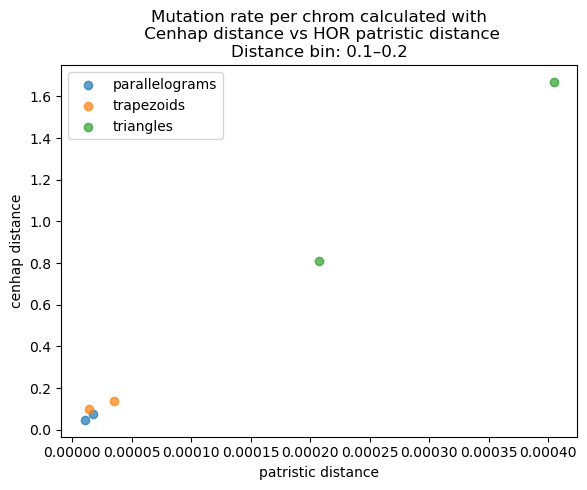

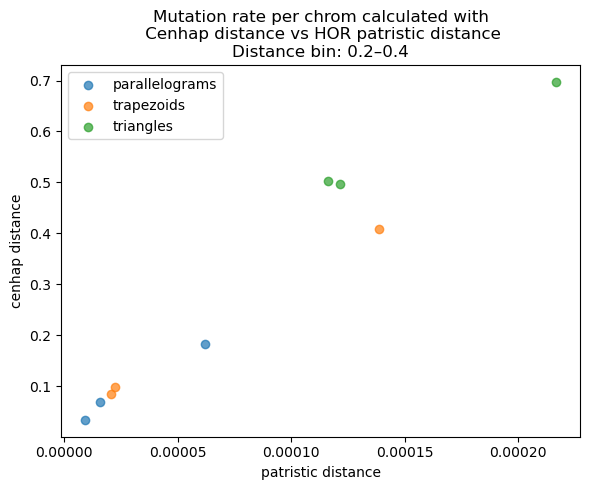

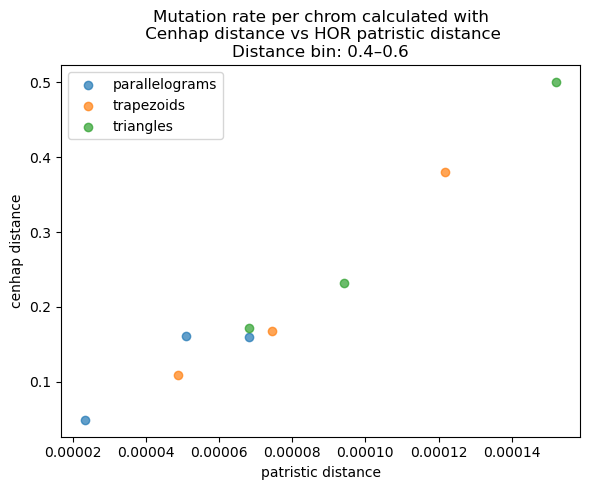

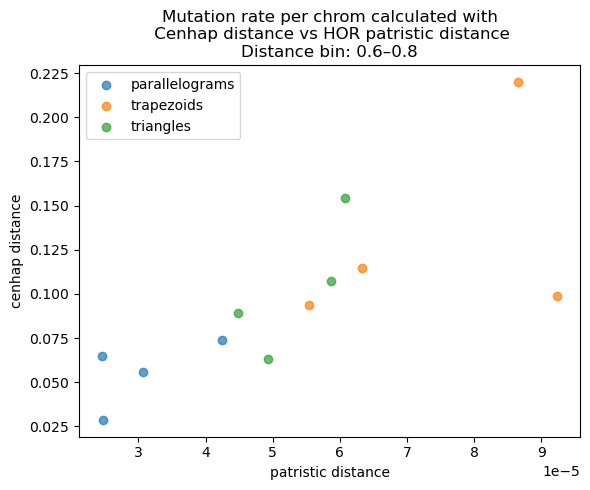

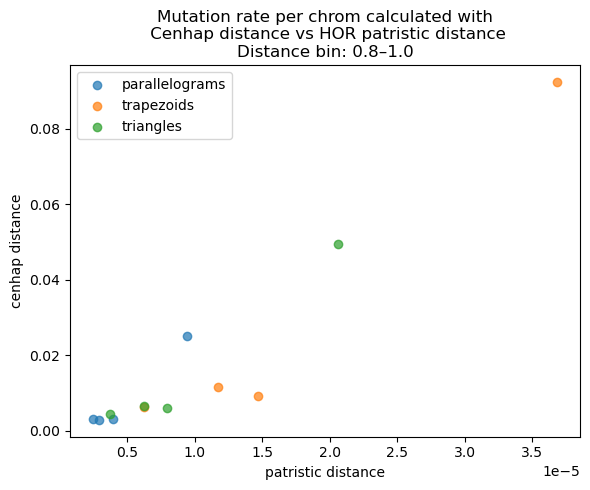

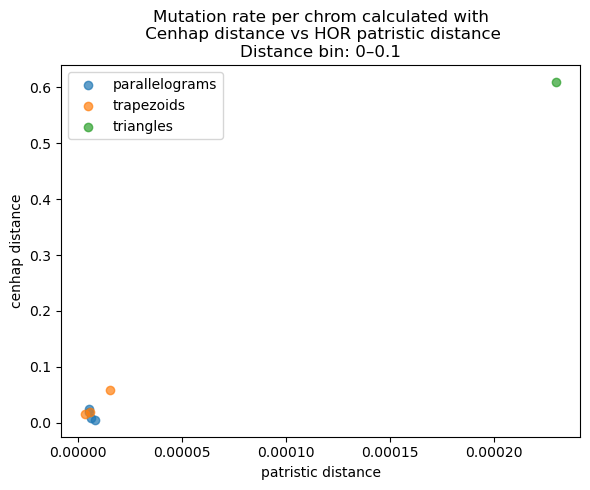

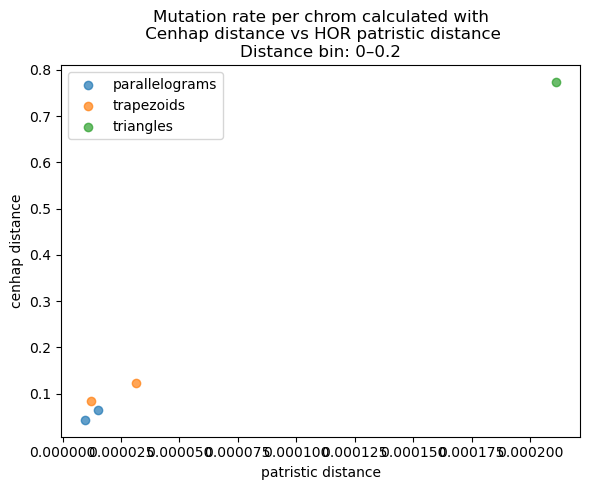

In [ ]:
import matplotlib.pyplot as plt

# Unique distance bins and shapes

df = merged_snp_hor.copy()

# Keep only selected chromosomes
keep_chroms = ["chr11", "chr12", "chr6", "chr17"]
df = df[df["chr"].isin(keep_chroms)]

bins = sorted(df["distance_bin"].unique())
shapes = sorted(df["shape"].unique())

# Assign a color to each shape
colors = plt.cm.tab10.colors  # tab10 has 10 distinct colors
shape_color_map = {shape: colors[i % len(colors)] for i, shape in enumerate(shapes)}

# Version 1: one figure per distance bin
for distance_bin in bins:
    subset = df[df["distance_bin"] == distance_bin]
    
    plt.figure(figsize=(6,5))
    
    for shape in shapes:
        group = subset[subset["shape"] == shape]
        plt.scatter(
            group["norm_mutation_rate_x"],
            group["norm_mutation_rate"],
            label=str(shape),
            color=shape_color_map[shape],
            alpha=0.7
        )
    
    plt.title(f"Mutation rate per chrom calculated with\n Cenhap distance vs HOR patristic distance\nDistance bin: {distance_bin}")
    plt.xlabel("patristic distance")
    plt.ylabel("cenhap distance")
    plt.tight_layout()
    plt.legend()
    plt.show()